# Chapter 1: Import Libraries

In [2]:
# Temel veri işleme kütüphaneleri
import pandas as pd
import numpy as np

# Veri görselleştirme için
import matplotlib.pyplot as plt
import seaborn as sns

# NLP için gerekli kütüphaneler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Makine öğrenmesi ve derin öğrenme için
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, Flatten, Embedding

# Ekstra ayarlamalar
import warnings
warnings.filterwarnings('ignore')


# Chapter 2: Importing the Data

## 2.1 Loading in the Data

In [3]:
import pandas as pd

# Read your csv file and define column names
columns = ['tweet_id', 'entity', 'sentiment', 'tweet_content']
data = pd.read_csv('/content/twitter_training.csv', names = columns)

# Replace 'Irrelevant' sentiment with 'Neutral'
data['sentiment'] = data['sentiment'].replace('Irrelevant', 'Neutral')

# Look at your data
data.head()

,tweet_id,entity,sentiment,tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


## 2.2 Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_id       74682 non-null  int64 
 1   entity         74682 non-null  object
 2   sentiment      74682 non-null  object
 3   tweet_content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


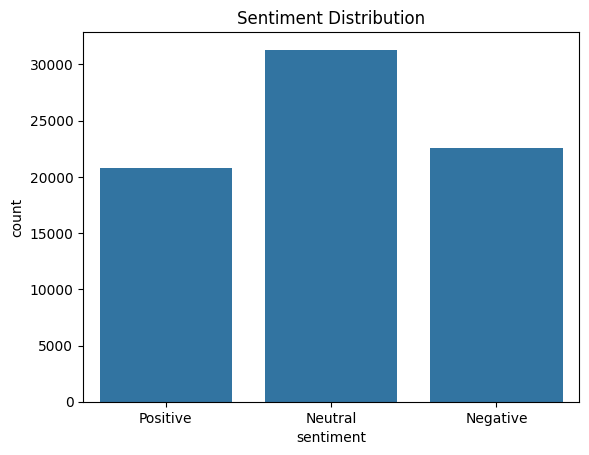

In [4]:
# Veri setinin genel istatistiksel özetine bakma
data.info()

# Eksik değerlere bakma
data.isnull().sum()

# Sınıf dağılımını görselleştirme
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution')
plt.show()


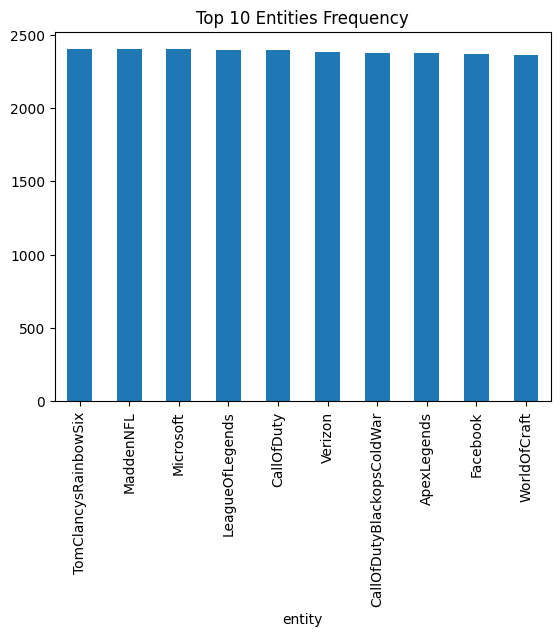

In [5]:
entities = data['entity'].value_counts()
entities[:10].plot(kind='bar')
plt.title('Top 10 Entities Frequency')
plt.show()

# Chapter 3: Data Preparation

## 3.1 Cleaning the Comments

In [6]:
import pandas as pd
import re

def clean_text(text):
    # Eğer metin değilse, boş stringe çevir
    if not isinstance(text, str):
        return ""
    # URL'leri, mentionları ve özel karakterleri kaldırma
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = text.lower()  # Metni küçük harfe çevirme
    text = re.sub(r'[^\w\s]', '', text)  # Noktalama işaretlerini kaldırma
    return text

# Veriyi temizleme
data['Cleaned_Text'] = data['tweet_content'].apply(clean_text)
data.head()

,tweet_id,entity,sentiment,tweet_content,Cleaned_Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you all
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...


## 3.2 Tokenization and Lemmatization

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Gerekli NLTK veri setlerini indir
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)
    # Durak kelimeleri filtreleme
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Tokenization ve lemmatization işlemi
data['Processed_Text'] = data['Cleaned_Text'].apply(tokenize_and_lemmatize)
data.head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tweet_id,entity,sentiment,tweet_content,Cleaned_Text,Processed_Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting on borderlands and i will murder yo...,im getting borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...,coming border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you all,im getting borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...,im coming borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...,im getting borderland 2 murder


## 3.3 Vectorization

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vektörleştirici oluşturma
vectorizer = TfidfVectorizer(max_features=5000)

# Metni vektörleştirme
X = vectorizer.fit_transform(data['Processed_Text']).toarray()
y = data['sentiment']


#Chapter 4: Model Training

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Etiketleri sayısal değerlere çevirme
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['sentiment'])

# Veriyi eğitim ve test seti olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli oluşturma
model = Sequential()
model.add(Dense(8, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # Çıkış katmanındaki nöron sayısını 4'e ayarladık

# Modeli derleme
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(X_train, y_train, epochs=3, batch_size=4, validation_data=(X_test, y_test))


Epoch 1/3
14937/14937 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.5295 - loss: 0.9558 - val_accuracy: 0.6863 - val_loss: 0.7317
Epoch 2/3
14937/14937 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - accuracy: 0.6487 - loss: 0.7771 - val_accuracy: 0.7091 - val_loss: 0.6692
Epoch 3/3
14937/14937 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.6702 - loss: 0.7257 - val_accuracy: 0.7189 - val_loss: 0.6411


# Chapter 5: Testing the Model

In [10]:
def predict(text, entity):
    processed_text = clean_text(text)
    processed_text = tokenize_and_lemmatize(processed_text)
    vectorized_text = vectorizer.transform([processed_text]).toarray()
    prediction = model.predict(vectorized_text)
    sentiment = ['Negative', 'Neutral', 'Positive'][np.argmax(prediction)]
    return sentiment

# Örnek bir cümle ile tahmin
sentence = "I love the new features of the Windows!"
entity = "Microsoft"
print(f"Sentiment: {predict(sentence, entity)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Sentiment: Positive


## Chapter 6: Bonus - CNN Model

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# CNN modelini kurma
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=X_train.shape[1], output_dim=64, input_length=X_train.shape[1]))  # Embedding boyutunu küçülttük
cnn_model.add(Conv1D(32, kernel_size=3, activation='relu'))  # Filtre sayısını azalttık (32)
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(64, activation='relu'))  # Dense katmanındaki nöron sayısını azalttık (64)
cnn_model.add(Dropout(0.3))  # Dropout oranını düşürdük (0.3)
cnn_model.add(Dense(3, activation='softmax'))

# CNN modelini derleme
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# CNN modelini eğitme
cnn_model.fit(X_train, y_train, epochs=2, batch_size=4, validation_data=(X_test, y_test))


Epoch 1/2
14937/14937 ━━━━━━━━━━━━━━━━━━━━ 789s 53ms/step - accuracy: 0.4171 - loss: 1.0839 - val_accuracy: 0.4143 - val_loss: 1.0849
Epoch 2/2
14937/14937 ━━━━━━━━━━━━━━━━━━━━ 757s 50ms/step - accuracy: 0.4204 - loss: 1.0818 - val_accuracy: 0.4143 - val_loss: 1.0835
